In [18]:
import tensorflow as tf
import numpy as np
from functools import wraps
from pyDOE.doe_lhs import lhs
import matplotlib.pyplot as plt

In [19]:
def call_logger(msg):
    def call_logger_outer(func):
        @wraps(func)
        def call_logger_inner(*args, **kwargs):
            str_args = ',\n'.join(str(arg) for arg in args)
            str_kwargs = ',\n'.join(str(key) + ' : ' + str(val) for key, val in kwargs.items())
            if kwargs: str_kwargs = ',\n' + str_kwargs
            print(f'[{func.__name__}](\n{str_args}{str_kwargs})\n:: {msg}')
            returns = func(*args, **kwargs)
            return returns
        return call_logger_inner
    return call_logger_outer

@call_logger('Tracing gradn call!')
def gradn(y, x, n):
    if n < 1: return -1
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(x)
        if n > 1: u = gradn(y, x, n-1)
        if n == 1: u = y(x)
    return tape.gradient(u, x)

In [20]:
class Constraint:
    def __init__(self, domain, residual):
        self.domain = tf.constant(domain, dtype=tf.float32)
        self.residual = residual

In [21]:
class PINN():
    
    def __init__(self, model):
        self.model = model
        self._compiled = False
        self._constraints = None
        
    @property
    def constraints(self):
        return self._constraints
    
    @constraints.setter
    def constraints(self, constraints):
        self._constraints = constraints
    
    def save(self, model_name = 'pinn_model.h5'):
        self.model.save(model_name)

    def load_model(self, filename):
        self.model = tf.keras.models.load_model(filename)
    
    def compile(self, optimizer, loss, metrics, order = 1):
        self.optimizer = optimizer
        self.loss = loss
        
        def predict_U_hat_0(phi):
            u_hat = self.model(phi, training=True)
            return {'uhat': u_hat}
        
        def predict_U_hat_1(phi):
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(phi)
                u_hat = self.model(phi, training=True)
            return {'uhat': u_hat, 'jac': tape.batch_jacobian(u_hat, phi)}
        
        def predict_U_hat_2(phi):
            with tf.GradientTape(watch_accessed_variables=False) as tape0:
                tape0.watch(phi)
                with tf.GradientTape(watch_accessed_variables=False) as tape1:
                    tape1.watch(phi)
                    u_hat = model(phi, training=True)
                jac = tape1.batch_jacobian(u_hat, phi)
            return {'uhat': u_hat, 'jac': jac, 'hess': tape0.batch_jacobian(jac, phi)}
        
        if order == 0: self.predict_U_hat = predict_U_hat_0
        elif order == 1: self.predict_U_hat = predict_U_hat_1
        elif order == 2: self.predict_U_hat = predict_U_hat_2    
        else: raise RuntimeError(f'PINN currently does not support order {order} ODEs.')
        
        self._compiled = True
    
    @tf.function
    @call_logger('Tracing model call..!')
    def __call__(self, phi, training=False):
        return self.model(phi, training=training)
    
    
    @tf.function
    #@call_logger('Tracing training call..!')
    def train_step(self):
        trainable_params = self.model.trainable_variables
        with tf.GradientTape() as model_tape:
            resloss = 0
            for constraint in self.constraints:
                domain, residual = constraint.domain, constraint.residual
                U_hat = self.predict_U_hat(domain)
                resloss += self.loss(residual(U_hat), tf.constant(0.0, dtype=tf.float32))
        
        gradients = model_tape.gradient(resloss, trainable_params)
        self.optimizer.apply_gradients(zip(gradients, trainable_params))
        return resloss
            
    
    def fit(self, constraints=None, epochs=1):
        if constraints is None: constraints = self.constraints 
        assert self._compiled, 'PINN object must be compiled before training.'
        for epoch in range(epochs):
            
            loss_value = self.train_step()
            
            if epoch % 1000 == 0:
                print(
                    "Training loss at epoch %d: %.4f"
                    % (epoch, float(loss_value))
                )


# Linear Differential Equation
The model will be trained to solve the equation $\frac{dy}{dx} = y$ with $y(0) = 1$ for interval $x \in [0, 2]$ . We know that the solution of this equation is $y=e^x.$

In [22]:
def ic_residual(U_hat):
    return U_hat['uhat'] - 1.0

ic_constraint = Constraint(
    [[0]],
    ic_residual
)

def de_residual(U_hat):
    return U_hat['uhat'] - U_hat['jac'][:,:,0]

de_constraint = Constraint(
    2 * lhs(1, 100),
    de_residual
)
model = tf.keras.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(1)
])

epochs = 5000
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.MeanSquaredError()

pinn = PINN(model)
pinn.constraints = [de_constraint, ic_constraint]
pinn.compile(optimizer, loss, ['mae'], order=1)
pinn.fit(epochs=epochs)

Training loss at epoch 0: 1.0949
Training loss at epoch 1000: 0.0419
Training loss at epoch 2000: 0.0006
Training loss at epoch 3000: 0.0001
Training loss at epoch 4000: 0.0000


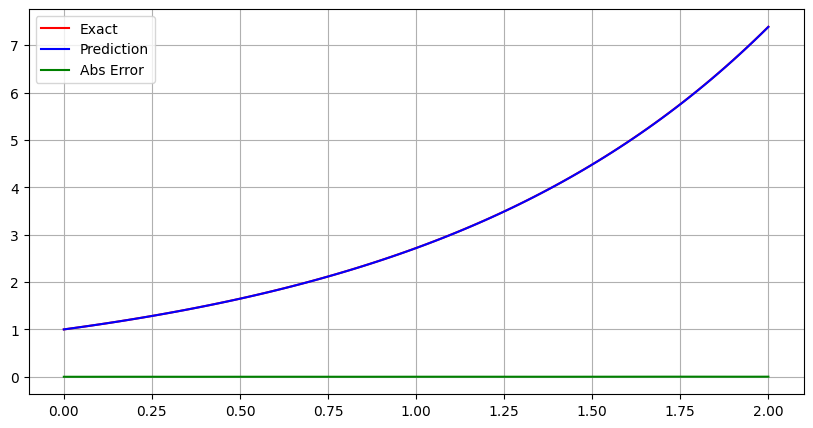

In [23]:
x_test = np.linspace(0, 2, 100).reshape((100,1))
y_true = np.exp(x_test)
y_pred = model(x_test)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
ax.plot(x_test, y_true, 'r-', label='Exact')
ax.plot(x_test, y_pred, 'b-', label='Prediction')
ax.plot(x_test, np.abs(y_true - y_pred), 'g-', label='Abs Error')
ax.legend(loc='best')
ax.grid(True)

The equation that will be solved is $\frac{d^2y}{dx^2} = -\pi^2 sin(\pi x)$ with $y(0) = 0$ and $\frac{dy}{dx}(0) = \pi$ for interval $x \in [0, 2 \pi]$ . For evaluation purposes only, we know that the solution of this equation is $y=sin(\pi x)$.

In [32]:
def ic0_residual(Uhat):
    return Uhat['uhat'] - 0

def ic1_residual(Uhat):
    return Uhat['jac'][:,:,0] - np.pi

def de_residual(Uhat):
    return Uhat['hess'][:,:,0,0] + np.pi**2 * tf.sin(np.pi * Uhat['uhat'])

ic0_constraint = Constraint(
    [[0]],
    ic0_residual
)
ic1_constraint = Constraint(
    [[0]],
    ic1_residual
)
de_constraint = Constraint(
    2*np.pi * lhs(1, 1000),
    de_residual
)

model = tf.keras.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(1)
])

epochs = 10000
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.MeanSquaredError()

pinn = PINN(model)
pinn.constraints = [de_constraint, ic0_constraint, ic1_constraint]
pinn.compile(optimizer, loss, ['mae'], order=2)
pinn.fit(epochs=epochs)

Training loss at epoch 0: 11.2150
Training loss at epoch 1000: 2.2276
Training loss at epoch 2000: 1.6771
Training loss at epoch 3000: 1.5001
Training loss at epoch 4000: 1.4355
Training loss at epoch 5000: 1.3418
Training loss at epoch 6000: 1.2336
Training loss at epoch 7000: 1.1477
Training loss at epoch 8000: 1.0811
Training loss at epoch 9000: 1.0223


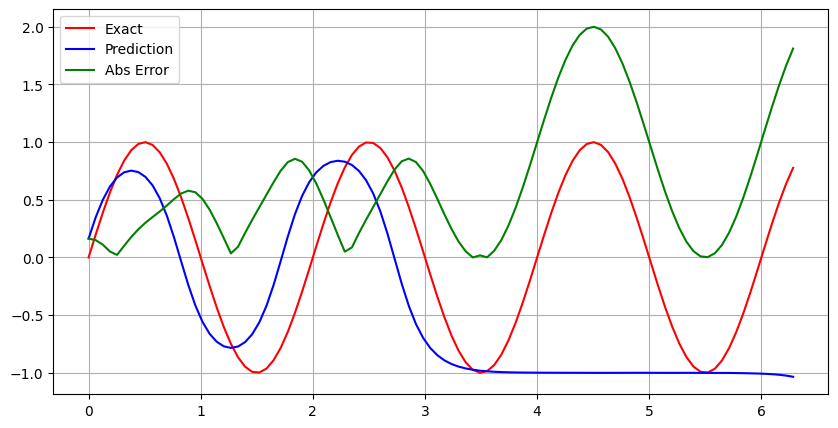

In [31]:
x_test = np.linspace(0, 2*np.pi, 100).reshape((100,1))
y_true = np.sin(np.pi * x_test)
y_pred = model(x_test)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
ax.plot(x_test, y_true, 'r-', label='Exact')
ax.plot(x_test, y_pred, 'b-', label='Prediction')
ax.plot(x_test, np.abs(y_true - y_pred), 'g-', label='Abs Error')
ax.legend(loc='best')
ax.grid(True)

In [27]:
(2*np.pi * lhs(1, 1000)).shape

(1000, 1)